In [42]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
import numpy as np

In [43]:
df = pd.read_csv("/content/Placements_Dataset - Sheet1.csv")

In [44]:

#Data Preprocessing
df.drop(columns=['sl_no'], inplace=True)

gender_encoder = LabelEncoder()
df['gender'] = gender_encoder.fit_transform(df['gender'])

ssc_scaler = MinMaxScaler()
df['ssc_p'] = ssc_scaler.fit_transform(df[['ssc_p']])


ssc_b_encoder = LabelEncoder()
df['ssc_b'] = ssc_b_encoder.fit_transform(df['ssc_b'])


hsc_scaler = MinMaxScaler()
df['hsc_p'] = hsc_scaler.fit_transform(df[['hsc_p']])


hsc_b_encoder = LabelEncoder()
df['hsc_b'] = hsc_b_encoder.fit_transform(df['hsc_b'])


hsc_s_encoder = LabelEncoder()
df['hsc_s'] = hsc_s_encoder.fit_transform(df['hsc_s'])


degree_scaler = MinMaxScaler()
df['degree_p'] = degree_scaler.fit_transform(df[['degree_p']])


degree_t_encoder = LabelEncoder()
df['degree_t'] = degree_t_encoder.fit_transform(df['degree_t'])


workex_encoder = OneHotEncoder()
workex_encoded = workex_encoder.fit_transform(df[['workex']]).toarray()
workex_df = pd.DataFrame(workex_encoded, columns=['workex_No', 'workex_Yes'])
df = pd.concat([df, workex_df], axis=1)
df.drop(columns=['workex'], inplace=True)


apt_test_scaler = MinMaxScaler()
df['apt_test_p'] = apt_test_scaler.fit_transform(df[['apt_test_p']])


specialisation_encoder = OneHotEncoder()
specialisation_encoded = specialisation_encoder.fit_transform(df[['specialisation']]).toarray()
specialisation_df = pd.DataFrame(specialisation_encoded, columns=['specialisation_Mkt&HR', 'specialisation_Mkt&Fin'])
df = pd.concat([df, specialisation_df], axis=1)
df.drop(columns=['specialisation'], inplace=True)


mba_scaler = MinMaxScaler()
df['mba_p'] = mba_scaler.fit_transform(df[['mba_p']])


status_encoder = LabelEncoder()
df['status'] = status_encoder.fit_transform(df['status'])


df.rename(columns={'status': 'placed'}, inplace=True)


cols = [col for col in df.columns if col != 'placed'] + ['placed']
df = df[cols]
salary_bands = [(0, 250000), (250000, 350000), (350000, 450000), (450000, 550000), (550000, float('inf'))]
labels = [1, 2, 3, 4, 5]

def map_salary_to_band(salary):
    for i, (lower, upper) in enumerate(salary_bands):
        if salary >= lower and salary < upper:
            return labels[i]
    return labels[-1]

df['salary_band'] = df['salary'].apply(map_salary_to_band)

df.loc[df['placed'] == 0, 'salary'] = np.nan
df.loc[df['placed'] == 0, 'salary_band'] = np.nan
df.drop(columns=['salary'], inplace=True)
df['salary_band'].fillna(0, inplace=True)

In [45]:
df.head()


,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,apt_test_p,mba_p,workex_No,workex_Yes,specialisation_Mkt&HR,specialisation_Mkt&Fin,placed,salary_band
0,1,0.538240,1,0.889621,1,1,0.195122,2,0.104167,0.284483,1.0,0.0,0.0,1.0,1,2.0
1,1,0.792414,0,0.680890,1,2,0.670244,2,0.760417,0.564843,0.0,1.0,1.0,0.0,1,1.0
2,1,0.497011,0,0.510708,0,0,0.341463,0,0.520833,0.247001,1.0,0.0,1.0,0.0,1,2.0
3,1,0.311482,0,0.247117,0,2,0.048780,2,0.333333,0.308096,1.0,0.0,0.0,1.0,0,0.0
4,1,0.925788,0,0.602965,0,1,0.568293,0,0.975000,0.160795,1.0,0.0,1.0,0.0,1,3.0


In [46]:
correlation_with_placed = df.corr()['placed']
print(correlation_with_placed)

gender                    0.090670
ssc_p                     0.607889
ssc_b                     0.037297
hsc_p                     0.491228
hsc_b                     0.016945
hsc_s                     0.033442
degree_p                  0.479861
degree_t                 -0.020352
apt_test_p                0.127639
mba_p                     0.076922
workex_No                -0.276060
workex_Yes                0.276060
specialisation_Mkt&HR     0.250655
specialisation_Mkt&Fin   -0.250655
placed                    1.000000
salary_band               0.790013
Name: placed, dtype: float64


In [47]:

selected_columns = df.columns.difference(['placed'])

correlation_with_salary = df[selected_columns].corrwith(df['salary_band'])


print(correlation_with_salary)


apt_test_p                0.169656
degree_p                  0.388310
degree_t                  0.100417
gender                    0.166462
hsc_b                     0.034632
hsc_p                     0.421611
hsc_s                     0.100293
mba_p                     0.147027
salary_band               1.000000
specialisation_Mkt&Fin   -0.245613
specialisation_Mkt&HR     0.245613
ssc_b                     0.031572
ssc_p                     0.507075
workex_No                -0.286049
workex_Yes                0.286049
dtype: float64


In [48]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error

In [49]:
X_placement = df.drop(columns=['placed', 'salary_band'])
y_placement = df['placed']

X_salary = df.drop(columns=['placed'])
y_salary = df['salary_band']


In [50]:
X_train_placement, X_test_placement, y_train_placement, y_test_placement = train_test_split(X_placement, y_placement, test_size=0.2, random_state=42)
X_train_salary, X_test_salary, y_train_salary, y_test_salary = train_test_split(X_salary, y_salary, test_size=0.2, random_state=42)

In [51]:
placement_model = XGBClassifier()
placement_model.fit(X_train_placement, y_train_placement)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
salary_model = XGBRegressor()
salary_model.fit(X_train_salary, y_train_salary)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [53]:
placement_predictions = placement_model.predict(X_test_placement)
placement_accuracy = accuracy_score(y_test_placement, placement_predictions)
print("Placement Prediction Accuracy:", placement_accuracy)
print("Classification Report:")
print(classification_report(y_test_placement, placement_predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test_placement, placement_predictions))

Placement Prediction Accuracy: 0.813953488372093
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.83      0.94      0.88        31

    accuracy                           0.81        43
   macro avg       0.79      0.72      0.74        43
weighted avg       0.81      0.81      0.80        43

Confusion Matrix:
[[ 6  6]
 [ 2 29]]


In [54]:
salary_predictions = salary_model.predict(X_test_salary)
salary_rmse = mean_squared_error(y_test_salary, salary_predictions, squared=False)
print("Salary Band Prediction RMSE:", salary_rmse)

Salary Band Prediction RMSE: 0.00012900953457209026


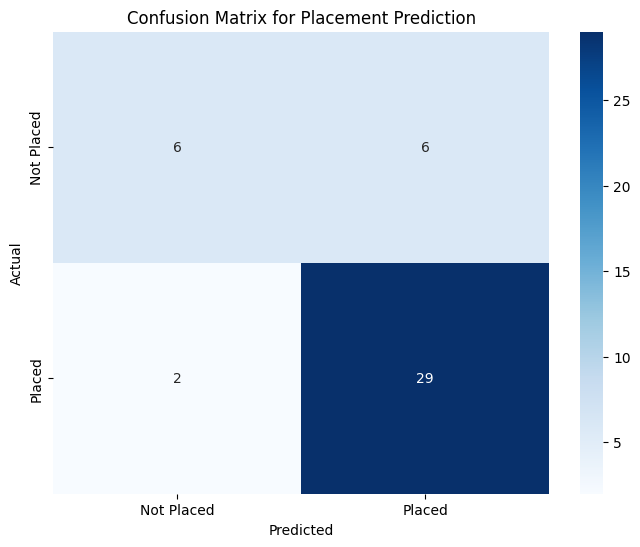

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_placement, placement_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Placed', 'Placed'], yticklabels=['Not Placed', 'Placed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Placement Prediction')
plt.show()


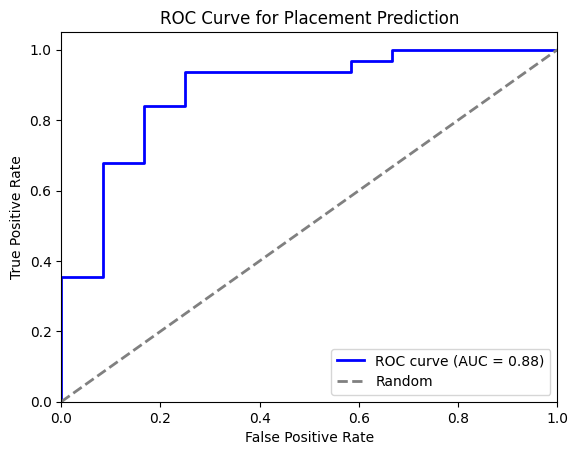

In [56]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test_placement, placement_model.predict_proba(X_test_placement)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Placement Prediction')
plt.legend(loc="lower right")
plt.show()


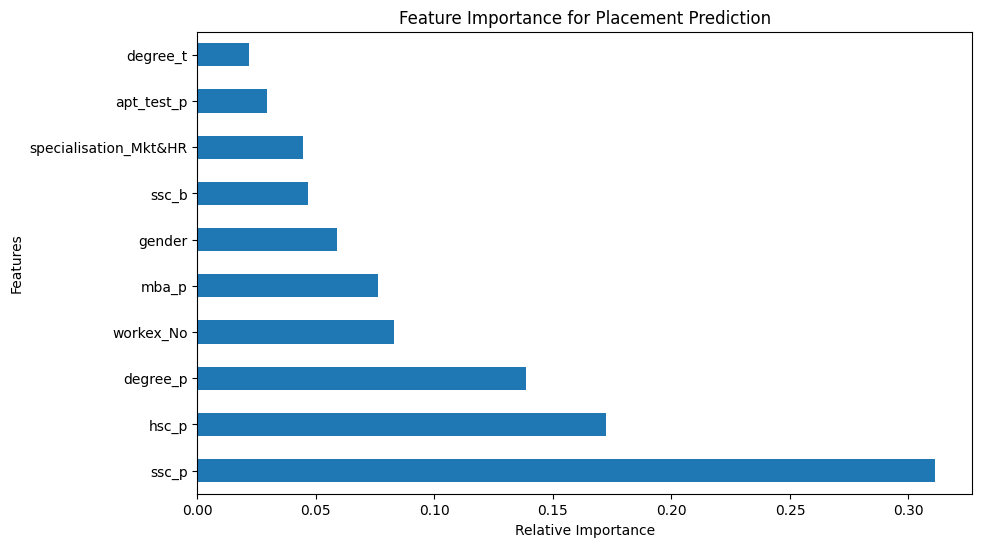

In [57]:

plt.figure(figsize=(10, 6))
feat_importances = pd.Series(placement_model.feature_importances_, index=X_train_placement.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance for Placement Prediction')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()
